<a href="https://colab.research.google.com/github/umbertogagl97/exercise/blob/main/Attacchi_ART_VGG16_stl10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import iniziali**

Import ART

In [13]:
#importa ART
!pip install adversarial-robustness-toolbox

Librerie

In [14]:
#Librerie
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
from art.utils import load_dataset

import cv2
from google.colab.patches import cv2_imshow

#import torch

#**Def variabili**

In [15]:
#salvataggio modello
model_save_name = 'model_DenseNet201'
path_model_save = F"/content/gdrive/My Drive/ModelliCNN/{model_save_name}" 

#immagini google
path_img_google="/content/gdrive/MyDrive/immagini_google/"

# **Collegamento google driv**e

In [16]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Dataset**

Load dataset stl10

In [17]:
#10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
#96x96 pixels, colored.
(x_train, y_train), (x_test_tot, y_test_tot), min_, max_ = load_dataset(str("stl10")) #carica train e test set

In [18]:
print(x_train.shape,x_test_tot.shape)
#5000 immagini di train e 8000 di test: 500 train e 800 test per ogni classe

(5000, 96, 96, 3) (8000, 96, 96, 3)


Riduzione training set

In [31]:
#x_train, y_train = x_train[:500], y_train[:500] #prende solo le prime 500 immagini di training

#test set ridotto
x_test, y_test = x_test_tot[:500], y_test_tot[:500]

#test set totale
#x_test, y_test = x_test_tot, y_test_tot

Stampa dimensioni

In [20]:
im_shape = x_train[0].shape
print("dimensioni immagine: ",im_shape)
print("dimensioni train set: ",x_train.shape)
print("dimensioni vettore classi reali: ",y_train.shape)
print("dimensioni test set: ",x_test.shape)

dimensioni immagine:  (96, 96, 3)
dimensioni train set:  (5000, 96, 96, 3)
dimensioni vettore classi reali:  (5000, 10)
dimensioni test set:  (8000, 96, 96, 3)


#Caricamento modello da drive

In [23]:
#load model
model= tf.keras.models.load_model(path_model_save)

# **Creazione modello**

load vgg16 e freeze livelli inferiori

In [8]:
#creazione rete usando vgg16 preaddestrata e aggiungendo gli ultimi livelli per adattarla al problema di 10 classi
from tensorflow.keras import applications as applications

#importa rete vgg16 addestrata sul dataset imagenet, esclude gli ultimi livelli e come input pongo dimensioni 96,96,3 
model_conv = applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(im_shape[0],im_shape[1],im_shape[2]))

# Freeze all the layers (non modifico i pesi dei livelli inferiori)
for layer in model_conv.layers[:]:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
74850304/74836368 [==============================] - 1s 0us/step


Aggiunta livelli superiori (per riaddestrare partire da qui)

In [22]:
# creo un modello aggiungendo livelli alla rete importata
model = Sequential()
# Add the vgg convolutional base model
model.add(model_conv)
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) #10: numero di valori in uscita (le classi)

#stampa info del modello
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
flatten_3 (Flatten)          (None, 17280)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              17695744  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                10250     
Total params: 36,027,978
Trainable params: 17,705,994
Non-trainable params: 18,321,984
_________________________________________________________________


# Training

Configura parametri modello

In [23]:
# Configure the model for training (setta i parametri del modello)
import keras
model.compile(
        loss=keras.losses.categorical_crossentropy, optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"]
    )

Training

In [24]:
# Train the model: divisione del training set in training e validation con rapporto 80-20
history= model.fit(x_train,y_train,epochs=20,batch_size=128)#,validation_split=0.2)
#batch 64, lr -5, 35 epoche = 70%
#batch 128, lr -3, 20 epoche = 98% --- test set 500 elementi: 69%, re-training senza validation acc test=69%
#batch 128, lr -3, 25 epoche, senza validation = 98% ---test set 500 elementi 70%
#batch 128, lr -4, 20 epoche = 92%
#batch 64, lr -4, 20 epoche = 95%

Train on 5000 samples
Epoch 1/20
5000/5000 [==============================] - 14s 3ms/sample - loss: 1.7135 - accuracy: 0.5320
Epoch 2/20
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.6996 - accuracy: 0.7618
Epoch 3/20
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.5098 - accuracy: 0.8206
Epoch 4/20
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.4170 - accuracy: 0.8568
Epoch 5/20
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.2980 - accuracy: 0.8950
Epoch 6/20
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.2471 - accuracy: 0.9190
Epoch 7/20
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.1688 - accuracy: 0.9526
Epoch 8/20
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.1298 - accuracy: 0.9628
Epoch 9/20
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.1104 - accuracy: 0.9700
Epoch 10/20
5000/5000 [==========

#Salvataggio modello

In [32]:
#salva modello su drive
model.save(path_model_save)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/ModelliCNN/model_DenseNet201/assets


# **Creazione classificatore ART**

In [24]:
#creazione classificatore di tipo Keras usando il modello addestrato, poiché ART supporta solo determinati classificatori
classifier = KerasClassifier(model=model, clip_values=(min_, max_)) #è un wrapper messo a disposizione da ART per creare un classificatore a partire da un modello addestrato

# Esempio resize

In [ ]:
#resized=cv2.resize(x_test1[1,:,:,:],(500,500),interpolation=cv2.INTER_CUBIC)

# **Testing su immagini originali**

In [25]:
# Evaluate the classifier on the test set 
value_preds=classifier.predict(x_test) #contiene i valori tra 0 e 1 predetti per ognuna delle 10 classi e per ogni immagine
preds = np.argmax(value_preds, axis=1) #(le predizioni vanno da 0 a 9 e indicano la classe predetta)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Accuracy on test set:", (acc * 100))
#print("classi predette: ",preds)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on test set: 77.60000000000001


# **Attacco**

Definizione attacco

In [26]:
# FGM
attack = FastGradientMethod(estimator=classifier, eps=0.1)

Generazione adversarial samples

In [32]:
x_test_adv = attack.generate(x=x_test,y=y_test) #aggiunge una perturbazione alle immagini del test set
#N.B. si possono passare le classi reali del test set (con y=y_test) e in questo caso FGM calcolerà le perturbazioni in modo che il classificatore
#non predica queste classi. Mentre, se non passo y_test, le calcolerà in modo da non fargli predire la classe predetta normalmente (la quale può essere diversa da quella reale
#se il classificatore non è corretto)

Calcolo perturbazioni

In [34]:
perturb=x_test_adv-x_test #calcolo della perturbazione

#N.B. problema nel calcolo della perturbazione, con la sottrazione si ha un'immagine [-1,1], di seguito è normalizzata in [0,1]
min_p, max_p = np.amin(perturb), np.amax(perturb)
perturb = (perturb - min_p) / (max_p - min_p)
#se non normalizzo, la funzione che uso per stampare ritaglia automaticamente nell'intervallo [0,1] quindi perdo informazioni

#**Testing su immagini perturbate**

In [33]:
# Evaluate the classifier on the adversarial samples FGM
value_preds_after=classifier.predict(x_test_adv)
preds_after = np.argmax(value_preds_after, axis=1)
acc_after = np.sum(preds_after == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Accuracy on adversarial samples:", (acc_after * 100))
#print("classi predette su test set perturbato: ",preds_after)

Accuracy on adversarial samples: 5.800000000000001


# **Stampa subplot**

Immagine  0


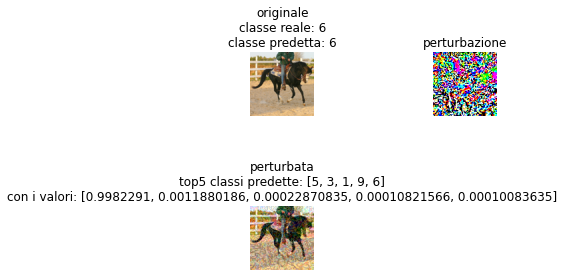

Immagine  1


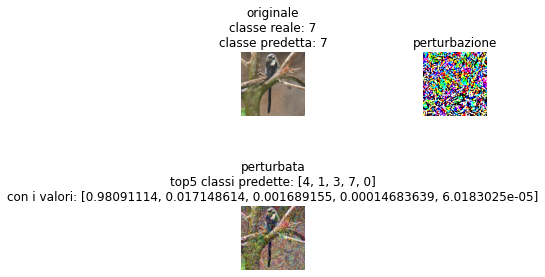

Immagine  2


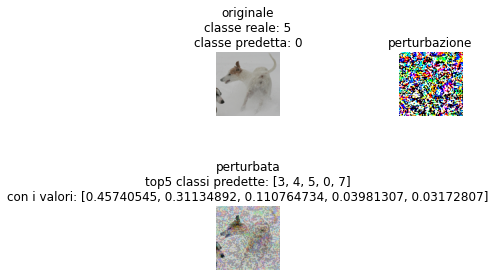

Immagine  3


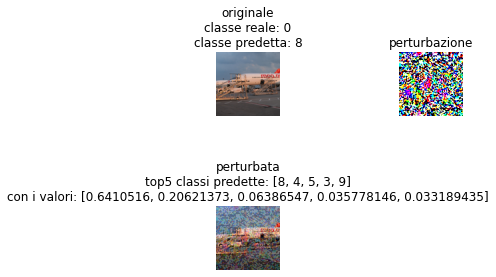

Immagine  4


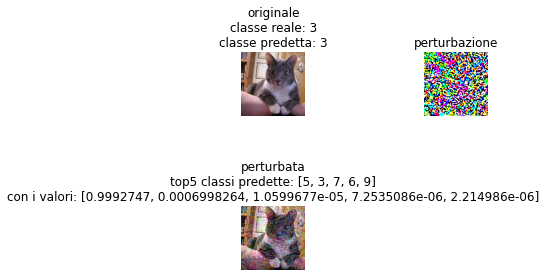

Immagine  5


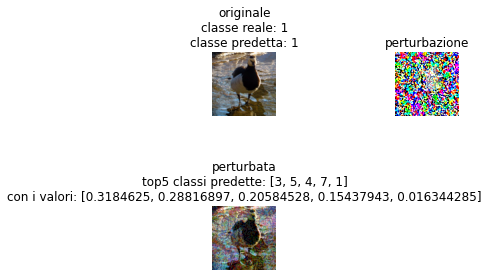

Immagine  6


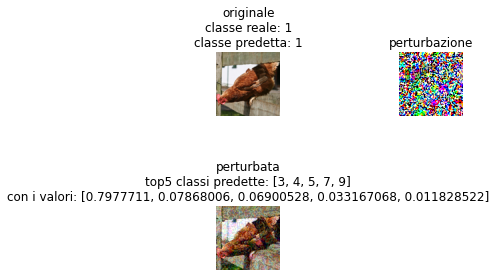

Immagine  7


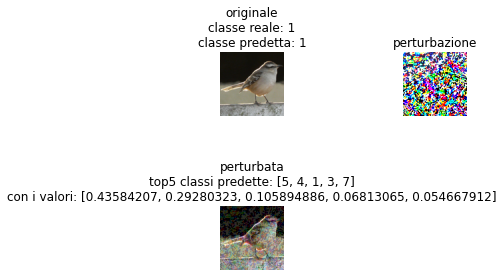

Immagine  8


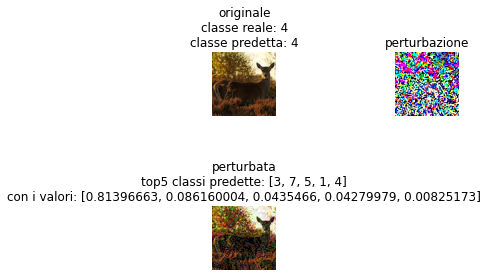

Immagine  9


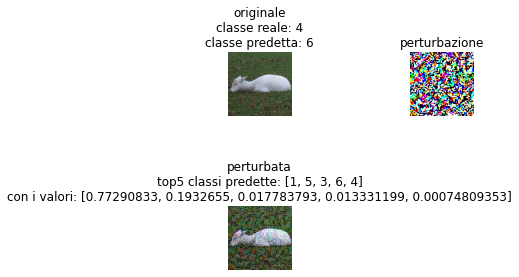

In [35]:
#stampa subplot

#cv2_imshow(cv2.hconcat([x_test[0,:,:,:]*255,x_test[1,:,:,:]*255,x_test[2,:,:,:]*255]))
#N.B. plt.imshow usa range 0,1 per immagini rgb, mentre cv2 usa 0,255
import matplotlib.pyplot as plt    
#nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
for i in range(10):#(x_test.shape[0]):
  value=value_preds_after[i,:]
  value_sorted=sorted(value,reverse=True)
  classes=[]
  for j in range(value.size) :
    ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
    classes.append(ind[0][0]) #classes è il vettore finale
  
  #in seguito per ogni immagine del test set si stampa un subplot
  fig = plt.figure()
  print("Immagine ",i)
  #originale
  ax1 = fig.add_subplot(321) #subplot con 3 righe e due colonne
  ax1.axis('off')
  ax1.imshow(cv2.rotate(x_test[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax1.title.set_text("originale\nclasse reale: "+str(np.argmax(y_test[i,:]))+"\nclasse predetta: "+str(preds[i]))
  #perturbazione
  ax2 = fig.add_subplot(322)
  ax2.imshow(cv2.rotate(perturb[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax2.axis('off')
  ax2.title.set_text("perturbazione")
  #perturbata
  ax3 = fig.add_subplot(325)
  ax3.imshow(cv2.rotate(x_test_adv[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax3.axis('off')
  ax3.title.set_text("perturbata\ntop5 classi predette: "+str(classes[:5])+"\ncon i valori: "+str(value_sorted[:5]))

  plt.show()

# Def funzione che perturba una singola immagine

In [ ]:
def perturb_img(img_g : np.ndarray,real_class : int):
  img_g=cv2.resize(img_g,(96,96))
  print("\nImmagine originale, classe reale: ",real_class)
  cv2_imshow(img_g)

  min_, max_ = np.amin(img_g), np.amax(img_g)
  normalized_img_g = (img_g - min_) / (max_ - min_) #normalizzo tra [0,1]
  normalized_img_g=normalized_img_g.reshape(1,96,96,3)

  pred_value=classifier.predict(normalized_img_g)
  pred=np.argmax(pred_value)
  print("Classe predetta: ",pred)
  print("Valori predetti per ogni classe:\n",pred_value)
  #generazione perturbazione
  img_adv = attack.generate(x=normalized_img_g)
  print("\nImmagine perturbata")
  cv2_imshow(img_adv[0,:,:,:]*max_)
  pred_value_adv=classifier.predict(img_adv)
  pred_adv=np.argmax(pred_value_adv)
  print("Classe predetta: ",pred_adv)
  print("Valori predetti per ogni classe:\n",pred_value_adv)

# Testing su immagine di google

In [ ]:
#test su immagini di google

#10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.

img_g1=cv2.imread(path_img_drive+"airplane.jpg")
img_g2=cv2.imread(path_img_drive+"dog.jpg")

perturb_img(img_g1,0)
perturb_img(img_g2,5)


